# Why Walk When You Can Zipline?

## Sam Daitzman and Jocelyn Jimenez
December, 2018

In [0]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last'

# import functions from the modsim.py module
from modsim import *

# Introduction
Although Olin is a very small campus, it is sometimes very tedious having to walk through various curved paths and flights of stairs. We noticed that there was great potential of a zip line from Olin’s Academic Center to West Hall. Initially there were multiple issues that arose. For instance, where will the landing spot be? In the case of our model, we believe it is best if the zip line ends on the corner room in West Hall on the second floor because it gives us the fastest access to most dorms in West Hall. If we were to ask “Which floor in the AC allows us to get faster to our destination?” the answer would be obvious, the 4th floor; but if you zipline at too steep an angle, you are likely to get injured. As a result, we decided to take into consideration the safety of the individual in order to make it a more useful model. Our model asks what the fastest safe zip line starting mount-point would be to get from the AC to West Hall as fast as (safely) possible. Stick around to find out where to anchor a zip-line in the Academic Center.

# Code Setup

In [0]:
# units!
year = UNITS.year
s = UNITS.second
N = UNITS.newton
kg = UNITS.kilogram
m = UNITS.meter

To prove the point that is is a good idea for  Olin to have a zip line, we modeled how the change in position will affect the velocity of the individual. We considered important initial/constant variables like the starting position, where (0,0) is at the tallest part of the Academic Center. For the following model, the starting velocity of the person in the x and y dimensions is 0 m/s, which can be seen below. 

In [0]:
#Starting position on the x and y axis
x_0 = (0 * m)
y_0 = (0 * m)

#Starting velocity in the x and y dimension
vx_0 = 0 * m / s
vy_0 = 0 * m / s

init = State(x=x_0,
             y=y_0,
             vx=vx_0,
             vy=vy_0)

Other constants include the mass, density, and area of the individual, gravity, drag force, the height of the West Hall window, the maximum landing speed and the end time. These constants are defined as the parameters of the model.

In [0]:
params = Params(init=init,
  
  # Mass of the individual ziplining
  m_human=70 * kg,
                
  #Gravity
  grav = Vector(0 * m / s ** 2, -9.81),
                
  #Mass Density of the Fluid
  rho = 1.275 * kg / m ** 3, 
                
  #Reference Area of individual
  area = 0.7 * m ** 2, 
                
  #Drag Coefficent 
  cd = 1.2,
                
  #End Time
  t_end=100e6 * s,
                
  #Height of West Hall Window in meters
  WH_window_abs_height = 59.3,
                
  #Maximum Landing Speed
  max_landing_speed = 12 * m / s
)

#Creates a system containing constants
def make_system(params, zipline):
    unpack(params)
    
    system = System(params, z=zipline)
    
    return system

In [0]:
make_system(params, Vector(100 * m, -25.1))

,values
init,x 0 meter y 0 me...
m_human,70 kilogram
grav,"[0.0 meter / second ** 2, -9.81 meter / second..."
rho,1.275 kilogram / meter ** 3
area,0.7 meter ** 2
cd,1.2
t_end,100000000.0 second
WH_window_abs_height,59.3
max_landing_speed,12.0 meter / second
z,"[100.0 meter, -25.1 meter]"


# Force Functions

We decided to calculate the different forces that might affect the zip-liner by including forces like gravity, drag, net and effective force. The cells below demonstrate functions and equations that contribute to the final velocity of the individual. We calculate the force of gravity pulling the zipliner downward and the drag force resisting their motion, and their sum is the net force. Then we calculate the effective force, which is the component of the force in line with the zip-line.

In [0]:
def earth_grav(m, g):
  return g * m

In [0]:
earth_grav(100*kg, make_system(params, Vector(100 * m, -25.1)).grav)

<Quantity([   0. -981.], 'kilogram * meter / second ** 2')>

In [0]:
def drag_force(rho, v, area, cd):
  
  #Direction
  direction= -v.hat()
  
  #Drag Equation
  drag = (1/2) * rho * v.mag**2 *area * cd
  
  #Drag as a Vector
  return direction * drag

In [0]:
drag_force(20 * kg / m ** 3, Vector(3 * m / s, 4), 10 * m ** 2, 0.8)

<Quantity([-1200. -1600.], 'kilogram * meter / second ** 2')>

In [0]:
def effective_force(state, system):
  """Calculates gravitational force for arbitrary objects"""
  x, y, vx, vy = state
  unpack(system)
  
  #Force of Gravity
  grav_f = earth_grav(m_human, grav)
  
  #Force of Drag
  drag_f = drag_force(rho, Vector(vx, vy), area, cd)
  
  #Net Force
  net_force = grav_f + drag_f
  
  #Effective Force
  effective_force = net_force.proj(z.hat())

  return effective_force

# Simulation Setup

In [0]:
def slope_func(state, t, system):
    x, y, vx, vy = state
    
    unpack(system)
    
    # make velocity
    v = Vector(vx, vy)
    
    # calculate force
    force = effective_force(state, system)
    
    # calculate acceleration
    a = force * (1/m_human)
    
    # cast acceleration to modsimvector
    a = Vector(a[0], a[1])
    
    # return velocity and acceleration
    return vx, vy, a.x, a.y
  
vx, vy, ax, ay = slope_func(init, 0, make_system(params, Vector(100 * m, -25.1)))
print(vx, vy, ax, ay)

0.0 meter / second 0.0 meter / second 2.3163759958833534 meter / second ** 2 -0.5814103749667217 meter / second ** 2


In [0]:
def event_func(state, t, system):
    x, y, vx, vy = state
    position = Vector(x, y)
    return position.mag - z.mag

In [0]:
event_func(init, 0, make_system(params, Vector(100 * m, -25.1)))

<Quantity(-103.10193984596022, 'meter')>

# Simulation

This simulation shows the zip-liner descending from the AC to West Hall from a particular starting height.

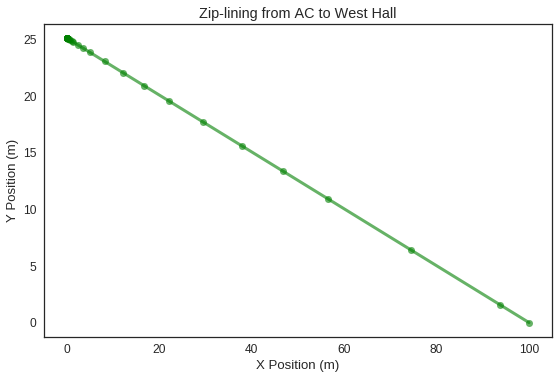

In [0]:
results, details = run_ode_solver(make_system(params, Vector(100 * m, -25.1)), slope_func, events=event_func, method='LSODA')
plot(results.x, results.y - z.y.magnitude, 'go-')
decorate(title='Zip-lining from AC to West Hall',
         xlabel='X Position (m)',
         ylabel='Y Position (m)')

This plot shows the position over time. Each point along the line is a different moment in time.

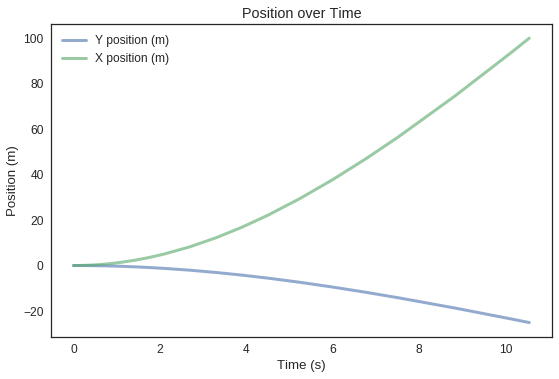

In [0]:
plot(results.y, label='Y position (m)')
plot(results.x, label='X position (m)')
decorate(title='Position over Time',
   xlabel='Time (s)',
   ylabel='Position (m)',
  legend=True)

These lines represent the change in X and Y position over time.

In [0]:
v_final = Vector(get_last_value(results.vx) * m / s, get_last_value(results.vy))
print(v_final.mag)

15.73897673293782 meter / second


The cell above shows how we obtain the arrival velocity.

# Sweeping Start Height

In [0]:
thresholds = linspace(60, 90, 10)
for i,e in enumerate(thresholds):
  thresholds[i] -= params.WH_window_abs_height
print(thresholds)

[ 0.7         4.03333333  7.36666667 10.7        14.03333333 17.36666667
 20.7        24.03333333 27.36666667 30.7       ]


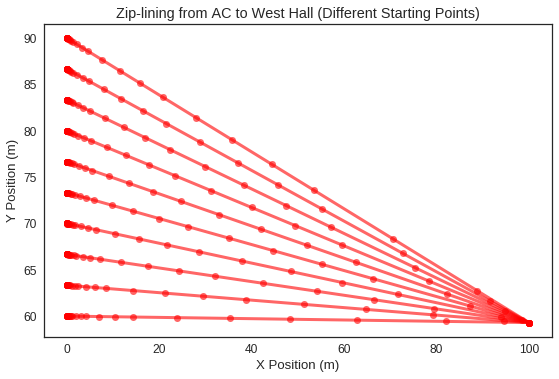

In [0]:
for y in thresholds:
  system = make_system(params, Vector(100 * m, -y))
  results, details = run_ode_solver(system, slope_func, events=event_func, method='LSODA')
  plot(results.x, results.y - z.y.magnitude + params.WH_window_abs_height, 'ro-')
  decorate(title='Zip-lining from AC to West Hall (Different Starting Points)',
  xlabel='X Position (m)',
  ylabel='Y Position (m)')

The plot above shows the process of zip-lining from various starting heights. We obtained the range of height differences using Olin College's blueprints, by comparing the absolute heights of the top of the AC, bottom of the AC, and our destination room in West Hall.

# Finding End Velocities

In [0]:
thresholds = linspace(60, 90, 15)
print(thresholds)

[60.         62.14285714 64.28571429 66.42857143 68.57142857 70.71428571
 72.85714286 75.         77.14285714 79.28571429 81.42857143 83.57142857
 85.71428571 87.85714286 90.        ]


In [0]:
def landing_speed(startHeight, params):
  height_y = startHeight - params.WH_window_abs_height
  system = make_system(params, Vector(100 * m, -height_y))
  results, details = run_ode_solver(system, slope_func, events=event_func, method='LSODA')
  v_final = Vector(get_last_value(results.vx) * m / s, get_last_value(results.vy))
  return v_final.mag

In [0]:
landing_speed(60, params)

<Quantity(2.651921049001805, 'meter / second')>

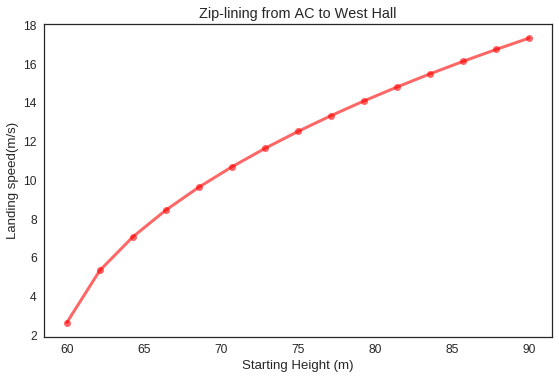

In [0]:
landing = SweepSeries()

for y in thresholds:
  landing[y] = landing_speed(y, params)
  
plot(landing, 'ro-') 
decorate(title='Zip-lining from AC to West Hall',
        xlabel='Starting Height (m)',
        ylabel='Landing speed(m/s)')

This plot shows the landing speed depending on starting height. By looking at this plot, we can choose a particular start height depending on our desired landing speed.

In [0]:
landing

,values
60.000000,2.651921049001805 meter / second
62.142857,5.343746587591299 meter / second
64.285714,7.074894599711499 meter / second
66.428571,8.456477911463677 meter / second
68.571429,9.63932336233028 meter / second
70.714286,10.688617419758609 meter / second
72.857143,11.63984596447041 meter / second
75.000000,12.514808133787712 meter / second
77.142857,13.327981059112659 meter / second
79.285714,14.08954798936296 meter / second


# Ideal Starting Height

We wanted to calculate our ideal starting height. We wrote an error function that approaches zero as the ideal starting height is approached. The maximum landing speed is determined based on the maximum safe landing speed of a hang-glider, which exerts analagous forces on a human.

In [0]:
def error_func(startHeight, params):
  return params.max_landing_speed - landing_speed(startHeight, params)

In [0]:
error_func(60, params)

<Quantity(9.348078950998195, 'meter / second')>

In [0]:
res = fsolve(error_func, 75, params)
print(res)

[73.71902744]


In [0]:
error_func(fsolve(error_func, 75, params)[0], params)

<Quantity(2.1085355683680973e-12, 'meter / second')>

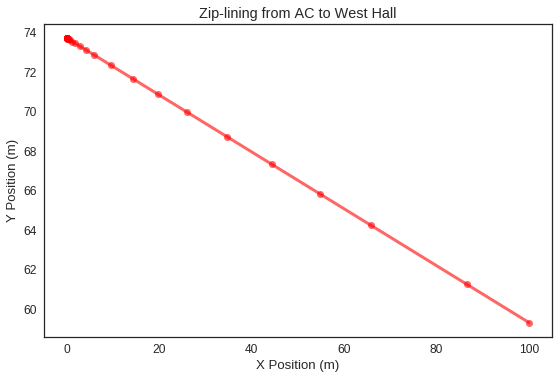

In [0]:
system = make_system(params, Vector(100 * m, -(fsolve(error_func, 75, params)[0] - params.WH_window_abs_height)))
results, details = run_ode_solver(system, slope_func, events=event_func, method='LSODA')
plot(results.x, results.y - z.y.magnitude + params.WH_window_abs_height, 'ro-')
decorate(title='Zip-lining from AC to West Hall',
xlabel='X Position (m)',
ylabel='Y Position (m)')

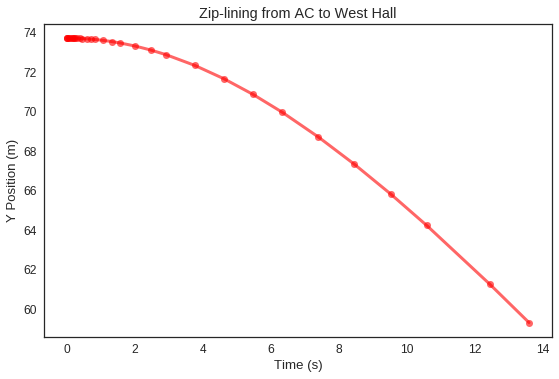

In [0]:
plot(results.y - z.y.magnitude + params.WH_window_abs_height, 'ro-')
decorate(title='Zip-lining from AC to West Hall',
xlabel='Time (s)',
ylabel='Y Position (m)')

This plot represents the ideal descent of a zip-liner from the AC to West Hall.

In [0]:
Vector(get_last_value(results.vx), get_last_value(results.vy)).mag

<Quantity(11.999999999997891, 'dimensionless')>

The zip-liner arrives incredibly close to, but slightly below, the maximum safe velocity.

# Conclusions
In this model, we find that the ideal starting height to arrive as quickly as possible (but at a safe speed) when zip-lining to West Hall would be around the third floor (about 15m above the first floor of the AC). The zip-liner would arrive safely at a speed slightly below 12 m/s. Before attempting this, we would want to conduct more precise modeling and account for the forces we've abstracted out of our model, like the tension in the rope and the changing normal force of the rope against the zip-liner through the handle.

# Future Steps: Questioning Assumptions. Straight Zipline?

We didn't have time to finish this modeling work, but with more work we might be able to simulate a more accurate zip-line curvature. To simplify our modeling, we assumed the line would be under infinite tension (in other words, perfectly straight) and the wheel would roll perfectly. For the wheel to behave efficiently, it's more likely that the line would have to maintain some slack. To get a more accurate estimate, we would continue this modeling work.

In [0]:
def calc_parabola_vertex(x1, y1, x2, y2, x3, y3):
		'''
		Adapted and modifed to get the unknowns for defining a parabola:
		http://stackoverflow.com/questions/717762/how-to-calculate-the-vertex-of-a-parabola-given-three-points
    With thanks to http://chris35wills.github.io/parabola_python/
		'''

		d = (x1-x2) * (x1-x3) * (x2-x3);
		A     = (x3 * (y2-y1) + x2 * (y1-y3) + x1 * (y3-y2)) / d;
		B     = (x3*x3 * (y1-y2) + x2*x2 * (y3-y1) + x1*x1 * (y2-y3)) / d;
		C     = (x2 * x3 * (x2-x3) * y1+x3 * x1 * (x3-x1) * y2+x1 * x2 * (x1-x2) * y3) / d;

		return A,B,C


In [0]:
range = linrange(60, 90, 5)

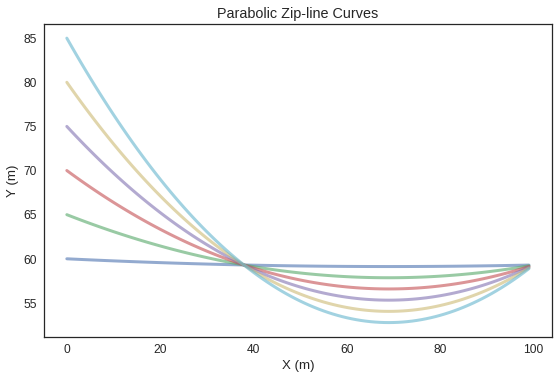

In [0]:
for i in range:
  xNum = linrange(0, 100)
  x1,y1=[0,i]
  x3,y3=[100,59.3]

  x2,y2=[50,y3-(y1-y3)/(2*pi)]
  
  #Calculate the unknowns of the equation y=ax^2+bx+c
  a,b,c=calc_parabola_vertex(x1, y1, x2, y2, x3, y3)

  zline = SweepSeries()
  dz = SweepSeries()

  for x in xNum:
    zline[x] = a * x ** 2 + b * x + c
    dz[x] = 2 * a * x + b

  plot(xNum, zline) 
decorate(title='Parabolic Zip-line Curves',
        xlabel='X (m)',
        ylabel='Y (m)')

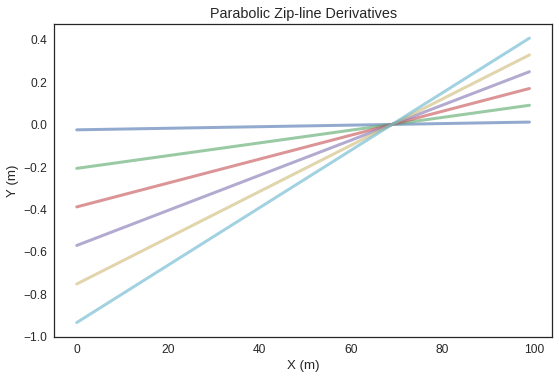

In [0]:
for i in range:
  xNum = linrange(0, 100)
  x1,y1=[0,i]
  x3,y3=[100,59.3]

  x2,y2=[50,y3-(y1-y3)/(2*pi)]
  
  #Calculate the unknowns of the equation y=ax^2+bx+c
  a,b,c=calc_parabola_vertex(x1, y1, x2, y2, x3, y3)

  zline = SweepSeries()
  dz = SweepSeries()

  for x in xNum:
    zline[x] = a * x ** 2 + b * x + c
    dz[x] = 2 * a * x + b

  plot(xNum, dz) 
decorate(title='Parabolic Zip-line Derivatives',
        xlabel='X (m)',
        ylabel='Y (m)')

In [0]:
def effective_parabolic_force(state, system):
  """Calculates gravitational force for arbitrary objects"""
  x, y, vx, vy = state
  unpack(system)
  
  #Force of Gravity
  grav_f = earth_grav(m_human, grav)
  
  #Force of Drag
  drag_f = drag_force(rho, Vector(vx, vy), area, cd)
  
  #Net Force
  net_force = grav_f + drag_f
  
  # Find parabola
  x1,y1=[0,z[0].magnitude] # AC startpoint
  x3,y3=[100,WH_window_abs_height] # WH endpoint

  x2,y2=[50,y3-(y1-y3)/(2*pi)] # midpoint
  
  #Calculate the unknowns
  a,b,c=calc_parabola_vertex(x1, y1, x2, y2, x3, y3)
  
  # Find the tangent vector
  tangent_vector = Vector(1, 2 * a * x + b)
  print(tangent_vector)
  
  #Effective Force
  effective_force = net_force.proj(tangent_vector.hat())

  return effective_force

In [0]:
def slope_func_parabolic(state, t, system):
    x, y, vx, vy = state
    
    unpack(system)
    
    # make velocity
    v = Vector(vx, vy)
    
    # calculate force
    force = effective_parabolic_force(state, system)
    
    # calculate acceleration
    a = force * (1/m_human)
    
    # cast acceleration to modsimvector
    a = Vector(a[0], a[1])
    
    # return velocity and acceleration
    return vx, vy, a.x, a.y

In [0]:
def event_func_parabolic(state, t, system):
    x, y, vx, vy = state
    position = Vector(x, y)
    return position.mag - z.mag

[ 1.         -1.48010425] dimensionless
[ 1.         -1.48010425] dimensionless
[ 1.         -1.48010425] dimensionless
[ 1.         -1.48010425] dimensionless
[ 1.         -1.48010425] dimensionless
[ 1.         -1.48009196] dimensionless
[ 1.         -1.48009196] dimensionless
[ 1.         -1.48005512] dimensionless
[ 1.         -1.48005512] dimensionless
[ 1.         -1.47999374] dimensionless
[ 1.         -1.47999374] dimensionless
[ 1.         -1.47994324] dimensionless
[ 1.         -1.47994324] dimensionless
[ 1.         -1.47988327] dimensionless
[ 1.         -1.47988327] dimensionless
[ 1.         -1.47981382] dimensionless
[ 1.         -1.47981382] dimensionless
[ 1.         -1.47961671] dimensionless
[ 1.         -1.47961672] dimensionless
[ 1.         -1.47936885] dimensionless
[ 1.         -1.47936885] dimensionless
[ 1.         -1.47907025] dimensionless
[ 1.         -1.47907025] dimensionless
[ 1.         -1.47839559] dimensionless
[ 1.         -1.47839563] dimensionless


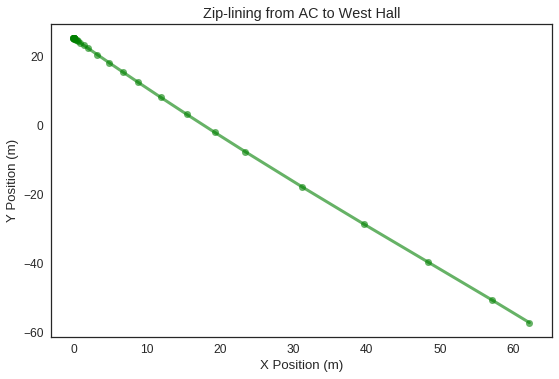

In [0]:
results, details = run_ode_solver(make_system(params, Vector(100 * m, -25.1)), slope_func_parabolic, events=event_func_parabolic, method='LSODA')
plot(results.x, results.y - z.y.magnitude, 'go-')
decorate(title='Zip-lining from AC to West Hall',
         xlabel='X Position (m)',
         ylabel='Y Position (m)')

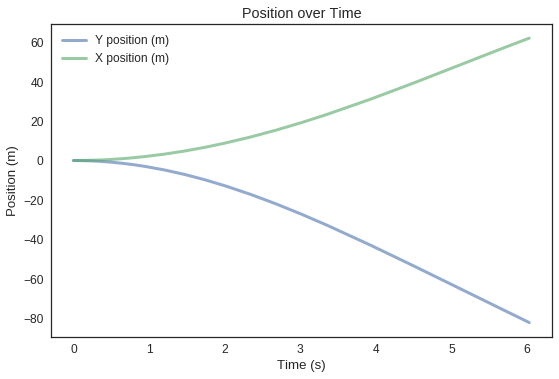

In [0]:
plot(results.y, label='Y position (m)')
plot(results.x, label='X position (m)')
decorate(title='Position over Time',
   xlabel='Time (s)',
   ylabel='Position (m)',
  legend=True)

Third floor near the ceiling

In [0]:
# Imports
from IPython.display import clear_output
import os
import time

# Install Python libraries
!pip3 install pandas seaborn sympy beautifulsoup4 lxml pint scipy==1.1.0 numpy

# Removes code before re-downloading it
!rm -rf ./ModSimPy
!rm -rf ./modsim.py

# Grabs ModSimPy
!git clone https://github.com/AllenDowney/ModSimPy.git
!cp "ModSimPy/code/modsim.py" .

# Resets kernel to flush outdated libraries (especially SciPy)
clear_output()
print("Configured for ModSimPy. Restarting kernel.")
time.sleep(1)
os._exit(0)

Configured for ModSimPy. Restarting kernel.
